In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

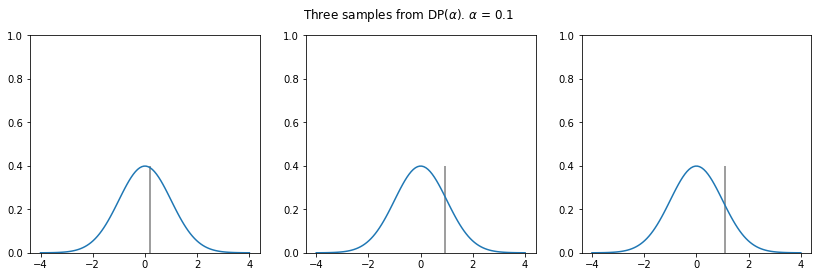

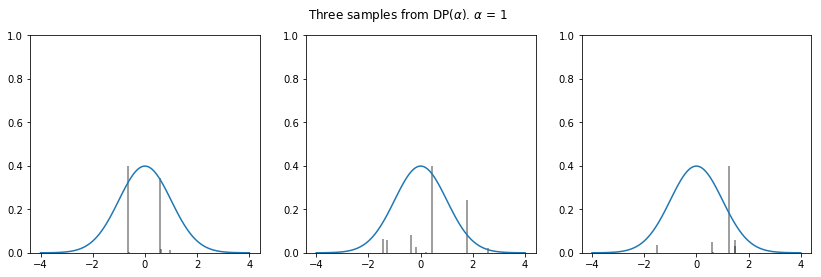

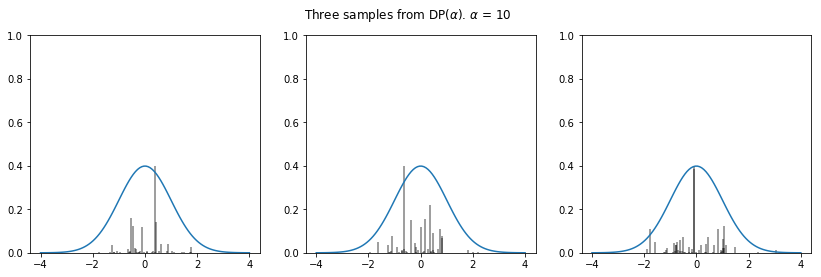

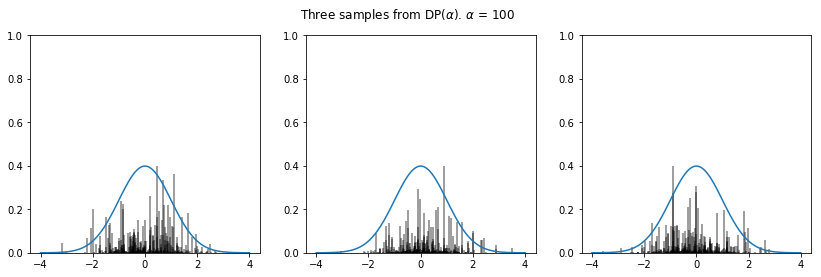

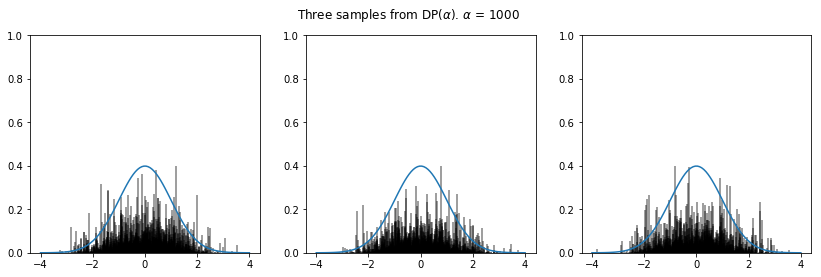

In [2]:
def dirichlet_process(h_0, alpha):
    """
    Truncated dirichlet process.
    :param h_0: (scipy distribution)
    :param alpha: (flt)
    :param n: (int) Truncate value.
    """
    n = max(int(5 * alpha + 2), 500)  # truncate the values. 
    pi = stats.beta(1, alpha).rvs(size=n)
    pi[1:] = pi[1:] * (1 - pi[:-1]).cumprod()  # stick breaking process
    theta = h_0(size=n)  # samples from original distribution
    return pi, theta
        
def plot_normal_dp_approximation(alpha, n=3):
    pi, theta = dirichlet_process(stats.norm.rvs, alpha)
    x = np.linspace(-4, 4, 100)
    
    plt.figure(figsize=(14, 4))
    plt.suptitle(r'Three samples from DP($\alpha$). $\alpha$ = {}'.format(alpha))
    plt.ylabel(r'$\pi$')
    plt.xlabel(r'$\theta$')
    pltcount = int('1' + str(n) + '0')
    
    for i in range(n):
        pltcount += 1
        plt.subplot(pltcount)
        pi, theta = dirichlet_process(stats.norm.rvs, alpha)
        pi = pi * (stats.norm.pdf(0) / pi.max())
        plt.vlines(theta, 0, pi, alpha=0.5)
        plt.ylim(0, 1)
        plt.plot(x, stats.norm.pdf(x))

np.random.seed(65)
for alpha in [.1, 1, 10, 100, 1000]:
    plot_normal_dp_approximation(alpha)

In [3]:
from sklearn.datasets import load_iris
import pandas as pd

df = pd.DataFrame(load_iris()['data'])
y = df.values
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

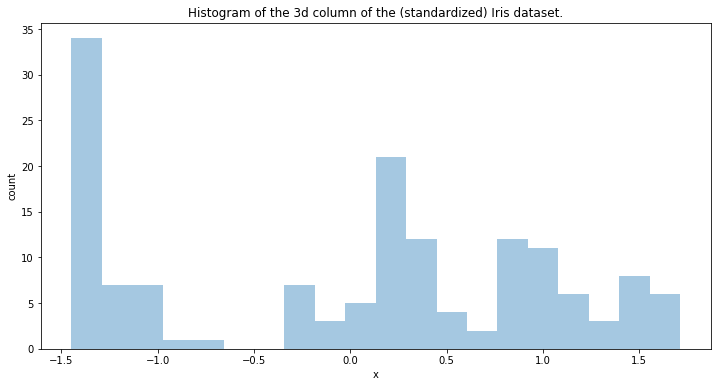

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.title('Histogram of the 3d column of the (standardized) Iris dataset.')
plt.xlabel('x')
plt.ylabel('count')
sns.distplot(y[:, 3], bins=20, kde=None)

In [5]:
import pymc3 as pm
from theano import tensor as tt

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

k = 35
m = pm.Model()
with m:

    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=k)
    pi = pm.Deterministic('pi', stick_breaking(beta))

    tau = pm.Gamma('tau', 1, 1, shape=k) 
    lambda_ = pm.Uniform('lambda', 0, 1, shape=k)
    mu0 = pm.Uniform('mu0', -3, 3, shape=k)
    
    mu = pm.Normal('mu', mu=mu0, tau=1, shape=k)
    obs = pm.NormalMixture('obs', w=pi, mu=mu, tau=lambda_ * tau, observed=y[:, 2])

/Users/arrigon5/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [6]:
with m: 
    step = None
    trace = pm.sample(500, tune=500, init='advi', random_seed=35171, step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 263.08:  13%|█▎        | 26982/200000 [00:18<01:52, 1543.26it/s]
Convergence achieved at 27100
Interrupted at 27,099 [13%]: Average Loss = 270.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, mu0, lambda, tau, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:47<00:00, 41.83draws/s]
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


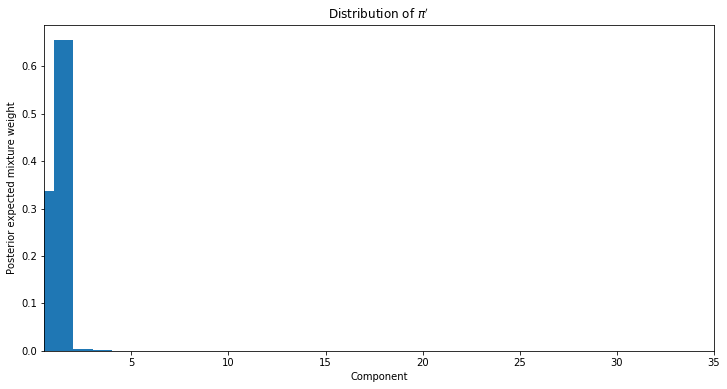

In [7]:
plt.figure(figsize=(12, 6))
plt.title(r"Distribution of $\pi'$")
plt.bar(np.arange(k) + 1 - 0.5, trace['pi'].mean(axis=0), width=1., lw=0);
plt.xlim(0.5, k);
plt.xlabel('Component');
plt.ylabel('Posterior expected mixture weight');

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ea73c18>],
      dtype=object)

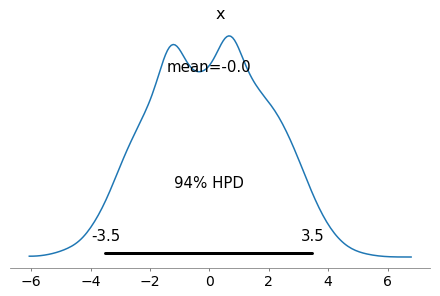

In [12]:
pm.plot_posterior(trace['mu'])

In [22]:
from numpy.random import dirichlet

dirichlet([10, 10, 10, 10])

array([0.25281039, 0.30048883, 0.23032963, 0.21637115])

In [25]:
stats.norm.pdf(0)

0.3989422804014327

In [34]:
offset = 1
theta = -20
theta_adj = theta + 90
theta_range = [theta_adj - offset, theta_adj + offset]
theta_range

[69, 71]